In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf  # Statsmodels is a Python module for statistics

from ISLP import load_data    # ISLP library for the book, it has built in functions and methods to build models 
from ISLP.models import (ModelSpec as MS, summarize) # It also has built-in data that can be loaded

from ISLP import confusion_table
from ISLP.models import contrast

from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib as mpl


%matplotlib inline                              
# For inline plotting 
%config InlineBackend.figure_format = 'svg'

mpl.rcParams['text.usetex'] = True

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

### 4.7.1 The Stock Market Data

We will use Smarket data which is a part of the ISLP library. It contains the precentage returns for the S&P stock index over 1,250 days from the beginning of 2001 until the end of 2005. For each date, it has the percentage returns for each of the five previous trading days from Lag 1 to 5. It also contains Volume: the number of shares traded on the previous day, in billions, Today: the percentage return on the date in question and Direction: whether the market was Up or Down on this day.   

In [2]:
df_Smarket = load_data('Smarket') 
df_Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [3]:
print(f'Smarket data has {df_Smarket.shape[0]} rows and {df_Smarket.shape[1]} columns')

Smarket data has 1250 rows and 9 columns


/var/folders/q0/lz7h2q596yx70_f664l6gv8h0000gn/T/ipykernel_25089/2317524349.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  market_CorrM = df_Smarket.corr()


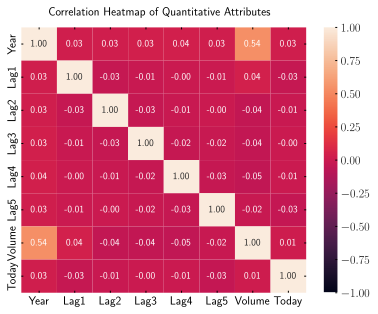

In [4]:
market_CorrM = df_Smarket.corr()

heatmp = sns.heatmap(market_CorrM, vmin=-1, vmax=1, annot = True, fmt=".2f", annot_kws={"size": 10}) # .corr() automatically ignores the qualitative 'Direction'

heatmp.set_title('Correlation Heatmap of Quantitative Attributes', fontdict={'fontsize':12}, pad=12);

### There is only appreciable correlation between year and volume 

<Axes: >

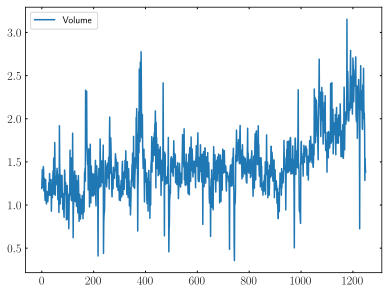

In [5]:
df_Smarket.plot(y = 'Volume')

### Volume exhibits an increasing mean average over the years. Note that we do not plot Volume with respect to Year attribute as it would generate a discrete plot. 

### 4.7.2 Logistic Regression 

- Predict 'Direction' using Lag1 through Lag5 and Volume 

In [6]:
X_df = df_Smarket.drop('Direction', axis = 1) # all attributes df


In [8]:
fit_cols = X_df.columns.drop(['Today','Year'])

X = sm.add_constant(X_df[fit_cols]) # add an intercept
y = df_Smarket.Direction == 'Up' # returns Up and Down to True and False that can be processed by the Logistic reg below

glm1 = sm.GLM(y,X,family=sm.families.Binomial())

results_glm1 = glm1.fit()

print(results_glm1.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Tue, 21 Nov 2023   Deviance:                       1727.6
Time:                        11:33:17   Pearson chi2:                 1.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002868
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.6

### From p-values no clear evidence for a relation between any variable and the response. Largest p-value is for Lag1 which has a negative coefficient, indicating that if the market has a positive return yesterday, it will likely to go down today. But as the p-value suggest we can not confirm this relationship with confidence.

In [9]:
results_glm1.params # coefficients of the logistic regression

const    -0.126000
Lag1     -0.073074
Lag2     -0.042301
Lag3      0.011085
Lag4      0.009359
Lag5      0.010313
Volume    0.135441
dtype: float64

In [10]:
results_glm1.pvalues # p values

const     0.600700
Lag1      0.145232
Lag2      0.398352
Lag3      0.824334
Lag4      0.851445
Lag5      0.834998
Volume    0.392404
dtype: float64

In [11]:
probs = results_glm1.predict() # return the predictions for classes as probabilities, if no argument provided, it does so on the training set

probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [12]:
# to turn these probabilities to up and down labels we can use prob > 0.5 thresholding 

class_pred = np.array(['Down']*df_Smarket.shape[0])

class_pred[probs > 0.5] = 'Up'

class_pred

array(['Up', 'Down', 'Down', ..., 'Up', 'Up', 'Up'], dtype='<U4')

In [13]:
confusion_matrix(df_Smarket['Direction'], class_pred, labels = ['Down','Up'])

array([[145, 457],
       [141, 507]])

In [14]:
# does the same job of the confusion_table function used below 

pd.crosstab(class_pred, df_Smarket['Direction'], rownames=['Predicted'], colnames = ['True']) 

True,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [15]:
confusion_table(class_pred,df_Smarket['Direction']) # built-in function defined in the ISLP library

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


### Diagonal elements of the Confusion table are True positives and True Negatives indicating the correct predictions of the classifier. To get the overall prediction accuracy, we can use np.mean()

In [26]:
print(f"Training accuracy of Log-Reg are {np.mean(df_Smarket['Direction'] == class_pred)*100:.2f} percent")
print("\n")
print(f"Training error of Log-Reg are {(1-np.mean(df_Smarket['Direction'] == class_pred))*100:.2f} percent")

Training accuracy of Log-Reg are 52.16 percent


Training error of Log-Reg are 47.84 percent


### Training accuracy and error are never good indicators of the true performance of the model. Therefore we have to train the model on a smaller subset of the data and test its accuracy on the held out data we will refer to as test data. For this purpose we will split the data to train and test sets choosing the boundry with respect to Year < 2005.

In [17]:
# Lets first do the splitting on the whole dataset 

trainslice = df_Smarket['Year']<2005

df_Smarket_train, df_Smarket_test = df_Smarket[trainslice], df_Smarket[~(trainslice)]

df_Smarket_test.shape # the last 252 instances constitutes the test data

(252, 9)

In [18]:
# Now repeat this with the Feature X and response y  

X_train, X_test = X[trainslice], X[~(trainslice)] # ~ used to flip the Booleans so that we take the rest Year > 2005
                                                                    # as the test set. 

y_train, y_test = y[trainslice], y[~(trainslice)]

In [19]:
glm1_train = sm.GLM(y_train, X_train, family = sm.families.Binomial())

glm1_train_res = glm1_train.fit()

print(glm1_train_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  998
Model:                            GLM   Df Residuals:                      991
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.55
Date:                Tue, 21 Nov 2023   Deviance:                       1381.1
Time:                        11:33:45   Pearson chi2:                     998.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002162
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1912      0.334      0.573      0.5

In [20]:
probs_test = glm1_train_res.predict(X_test)

plabels = np.array(['Down'] * X_test.shape[0])

plabels[probs_test > 0.5] = 'Up'

In [21]:
# Now get the test confusion matrix and the accuracy

true_train, true_test = df_Smarket['Direction'][trainslice], df_Smarket['Direction'][~(trainslice)]

pd.crosstab(plabels, true_test, rownames=['Predicted'], colnames = ['True']) 

True,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [22]:
# Accuracy and error on the test set 

print(f"Accuracy and Error rate of the Log-reg on the test set are {np.mean(plabels == true_test):.2f}, {np.mean(plabels != true_test):.2f}")

Accuracy and Error rate of the Log-reg on the test set are 0.48, 0.52


### As expected the model performs worse than the training set and it does so in a way that it is worse than random classifier!!!. p-values we obtained earlier might suggest us to remove some of the predictors when we are modelling as they might be generating not so informative variance on the model. Therefore below we refit the data using first two predictors with the highest p-values: Lag1 and Lag2

In [23]:
fit_cols2 = X_df.columns.drop(['Year','Today', 'Lag3', 'Lag4', 'Lag5', 'Volume'])

X2 = sm.add_constant(X_df[fit_cols2])

X2_train, X2_test = X2[trainslice], X2[~(trainslice)]

glm2_train = sm.GLM(y_train, X2_train, family = sm.families.Binomial())

glm2_train_res = glm2_train.fit()

print(glm2_train_res.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  998
Model:                            GLM   Df Residuals:                      995
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.70
Date:                Tue, 21 Nov 2023   Deviance:                       1381.4
Time:                        11:33:59   Pearson chi2:                     998.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001865
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0322      0.063      0.508      0.6

In [24]:
probs_test2 = glm2_train_res.predict(X2_test)

plabels2 = np.array(['Down'] * X2_test.shape[0])

plabels2[probs_test2 > 0.5] = 'Up'

pd.crosstab(plabels2, true_test, rownames=['Predicted'], colnames = ['True']) 

True,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [25]:
print(f"Overall accuracy of the model on the test set: {np.mean(plabels2 == true_test) * 100:.2f}%")
print('\n')
print(f"Accuracy with the days when log-reg predicts an increase: {106/sum(plabels2 == 'Up')*100:.2f}%")

Overall accuracy of the model on the test set: 55.95%


Accuracy with the days when log-reg predicts an increase: 58.24%


### Now the results improved a bit. 56% of daily movements (as compared to 52 percent of the original model) of the market (Up or Down) can be correctly predicted. On the other hand, on the days where the log-reg predicts an upward trend in the market, it has a 58 % accuracy rate. This could serve as an acceptable rate to build a strategy around it, i.e buying on days when the model predicts an increase and shorting on days it predicts a decrease (given that for each day we have the information of Lag1 and Lag2).

### Using the fitted model we can predict if a day with given values of Lag1 and Lag2 will have positive return or not

In [120]:
new_data = pd.DataFrame({'Lag1': [1.2, 1.5], 'Lag2': [1.1, -0.8]})

newX = sm.add_constant(new_data)

glm2_train_res.predict(newX)  # it seems like the market will go down for both of the days provided

0    0.479146
1    0.496094
dtype: float64

### 4.7.3 Linear Dicriminant Analysis

### Now we use LinearDiscriminantAnalysis() to fit the training observations (year < 2005). Since the LDA estimator automatically adds an intercept, we should remove the intercept column in the training feature matrices and also directly use the labels rather than Boolean vectors for y_train

In [30]:
lda = LDA(store_covariance=True)

In [37]:
X_train, X_test = [M.drop(columns = ['const']) for M in [X2_train,X2_test]]


y_train, y_test = df_Smarket.Direction[trainslice], df_Smarket.Direction[~(trainslice)]

lda_fit = lda.fit(X_train, y_train)



### Means of each class $\mu_1$ and $\mu_2$ (Up or Down) can be obtained by the ".means_" method which shows the average of each predictor within each class.

In [38]:
lda_fit.means_  # rows identifies classes (starting from Down then Up) and columns predictors. 

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

### There is a tendency for the previous 2 days returns to be negative on days when the market increases and a tendency for the previous day's returns to be positive on days when the market declines

In [39]:
lda_fit.priors_

array([0.49198397, 0.50801603])

In [40]:
lda_fit.classes_

array(['Down', 'Up'], dtype='<U4')

In [42]:
# The linear discriminant vectors can be found in the .scalings_ attribute 

lda_fit.scalings_

array([[-0.64201904],
       [-0.51352928]])

### These values provide the linear combination of Lag1 and Lag2 that are used to form the LDA decision rule. In other words these are the multipliers of the elements of $X = x$ in (the first term of the following equation) 

### $$ \delta_k (x) = x^T \bf{\Sigma}^{-1} \mu_k - \frac{1}{2} \mu_k^T \bf{\Sigma}^{-1} \mu_k + \log \pi_k $$

### which assigns an observation with predictors $x$ to a class $k$ for which $\delta_k$ is maximal. Therefore if $-0.64 \times Lag1 - 0.51 \times Lag2$ is large LDA classifier will predict an increase in the market, and otherwise a decline.



In [45]:
# get predictions 

lda_pred = lda_fit.predict(X_test)

pd.crosstab(lda_pred,y_test, rownames=['Predicted'], colnames = ['True'])

True,Down,Up
Predicted,,
Down,35,35
Up,76,106


### Notice that the LDA predictions are identical to that of Log-Reg on the test set, which is expected as their decision boundaries are both linear. In the LDA, the linear coefficients of the decision boundary are functions of the estimated variables $\pi_k, \bf{\Sigma}, \mu_k$ where as in logistic-regression these coefficients $\beta_0$ and $\beta_1$ are chosen to maximize the likelihood function

### $$ l(\beta_0, \beta_1) = \prod_{i:y_i = 1} p(x_i)\, \prod_{j:y_j = 0} (1 - p(x_j)),\quad\quad p(X) = \frac{e^{\beta_0 + \beta_1 X}}{1 + e^{\beta_0 + \beta_1 X}}$$ 

### Due to assumptions in LDA (multi-variate normality of features $X = (X_1, ..., X_p)$), we expect LDA to perform better than Log-Reg if this assumption holds but in general it does not.

In [47]:
# get probabilities in the test set 

lda_probs = lda_fit.predict_proba(X_test) # an array as long as the test set, with 0th column corresponding to Down and first corresponding to Up

In [50]:
# Convert the probabilities to Up and Down using 50% thresholding and check if they agree with the predictions lda_pred

np.all(np.where(lda_probs[:,1]>= 0.5, 'Up', 'Down') == lda_pred)

True

### For problems with more than two classes the predicted labels are chosen as the class whose posteriror probability is highest. We can use np.argmax() for this purpose which returns the indices of the maximum values along a specified axis. So np.argmax(lda_probs, 1) will return 1 when the probability corresponding Up column is larger and 0 otherwise.  

In [60]:
lda_fit.classes_

array(['Down', 'Up'], dtype='<U4')

In [57]:
np.all([lda_fit.classes_[col_i] for col_i in np.argmax(lda_probs, 1)] == lda_pred)

True

In [58]:
# We can also change the posterier probability threshold. For example, if we wish to predict a market decrease only if we are very certain that the market will indeed decrease on that day, we can ask for post. probability of at least 90 %. 

np.sum(lda_probs[:,0] > 0.9) # 0th index corresponds to Down class 

0

In [59]:
# No days in 2005 meet that threshold!

### 4.7.4 Quadratic Discriminant Analysis

In [61]:
qda = QDA(store_covariance=True)

qda_fit = qda.fit(X_train, y_train)

qda_fit.means_, qda_fit.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [62]:
# QDA classifier will estimate one covariance per class 

qda_fit.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [63]:
qda_pred = qda_fit.predict(X_test)

pd.crosstab(qda_pred,y_test, rownames=['Predicted'], colnames = ['True'])

True,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [65]:
# Overall accuracy rate and the accuracy of the classifier on the days it predicted Up

print(f"Overall accuracy rate of QDA classifier on the test set is {np.mean(qda_pred == y_test) * 100:.2f} percent")
print("\n")
print(f"Overall accuracy rate of QDA classifier on the test set is {121/(121+81) * 100:.2f} percent")

Overall accuracy rate of QDA classifier on the test set is 59.92 percent


Overall accuracy rate of QDA classifier on the test set is 59.90 percent


### Quite some improvement on the accuracy, suggesting that quadratic form of decision boundary assumed by QDA might capture the true relationship more accuractely than the linear forms assumed by LDA. 

### 4.7.5 Naive Bayes

In [66]:
NB = GaussianNB()

NB_fit = NB.fit(X_train, y_train)

NB_fit.classes_


array(['Down', 'Up'], dtype='<U4')

In [68]:
NB_fit.class_prior_

array([0.49198397, 0.50801603])

In [70]:
# Means and variances using theta_ and var_ methods, rows are classes, columns are predictors  

NB_fit.theta_ , NB_fit.var_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([[1.50355429, 1.53246749],
        [1.51401364, 1.48732877]]))

In [73]:
NB_pred = NB_fit.predict(X_test)

pd.crosstab(NB_pred,y_test, rownames=['Predicted'], colnames = ['True'])

True,Down,Up
Predicted,,
Down,29,20
Up,82,121


### Naive Bayes performs slightly worse than QDA but much better than LDA

In [74]:
print(f"Overall accuracy rate of NB classifier on the test set is {np.mean(NB_pred == y_test) * 100:.2f} percent")
print("\n")
print(f"Overall accuracy rate of NB classifier on the test set is {121/(121+82) * 100:.2f} percent")

Overall accuracy rate of NB classifier on the test set is 59.52 percent


Overall accuracy rate of NB classifier on the test set is 59.61 percent


In [75]:
# Posterier probabilities via .predict_proba

NB_fit.predict_proba(X_test)[:10]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413],
       [0.49121017, 0.50878983],
       [0.4921853 , 0.5078147 ],
       [0.48452749, 0.51547251],
       [0.48875624, 0.51124376],
       [0.48157179, 0.51842821]])

### 4.7.6 K-Nearest Neighbors

In [76]:
knn1 = KNeighborsClassifier(n_neighbors=1)

knn1_fit = knn1.fit(X_train, y_train)

knn1_pred = knn1_fit.predict(X_test)

pd.crosstab(knn1_pred,y_test, rownames=['Predicted'], colnames = ['True'])

True,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [77]:
print(f"Overall accuracy rate of 1NN classifier on the test set is {np.mean(knn1_pred == y_test) * 100:.2f} percent")
print("\n")
print(f"Overall accuracy rate of  1NN classifier on the test set is {83/(83+68) * 100:.2f} percent")

Overall accuracy rate of 1NN classifier on the test set is 50.00 percent


Overall accuracy rate of  1NN classifier on the test set is 54.97 percent


In [78]:
# Maybe K = 1 is overly flexible method, lets increase K

knn3 = KNeighborsClassifier(n_neighbors=3)

knn3_fit = knn3.fit(X_train, y_train)

knn3_pred = knn3_fit.predict(X_test)

pd.crosstab(knn3_pred,y_test, rownames=['Predicted'], colnames = ['True'])

True,Down,Up
Predicted,,
Down,48,55
Up,63,86


In [80]:
print(f"Overall accuracy rate of 3NN classifier on the test set is {np.mean(knn3_pred == y_test) * 100:.2f} percent")
print("\n")
print(f"Overall accuracy rate of  3NN classifier on the test set is {86/(86+63) * 100:.2f} percent")

Overall accuracy rate of 3NN classifier on the test set is 53.17 percent


Overall accuracy rate of  3NN classifier on the test set is 57.72 percent


### The results are imporved slightly, but it turns out that increasing K further provides no improvement. It seems that for the Smarket data, and this train/test split, QDA gives the best results among the models we have considered. 

### Lets focus on a data set where KNN approach gives much better results using the Caravan dataset of the ISLP library: 85 predictors that measure demographic characteristic for 5.822 individuals. The response is Purchase, indicating whether or not a given person purchase a caravan insurance policy

In [2]:
df_Caravan = load_data('Caravan')

Purchase = df_Caravan.Purchase

Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [3]:
print(f"Only {np.mean(Purchase == 'Yes') * 100:.2f} % of the individuals bought an insurance policy in the data set")

Only 5.98 % of the individuals bought an insurance policy in the data set


### KNN classifier predicts a class of given test observations by identifying the nearest observations to it, therefore the scale of the features are very important in determining the "weight's" of the predictors. Since the distance is in absolute value, features with large scale values will have more impact as compared to the ones that exhibhit small scale variations. We therefore scale the features matrix with StandardScaler of sklearn

In [4]:
df_feature = df_Caravan.drop(columns= ['Purchase'])

scale = StandardScaler(with_mean=True, with_std=True, copy=True)

scale.fit(df_feature)

StandardScaler()

In [5]:
X_std = scale.transform(df_feature)

In [6]:
df_feature_std = pd.DataFrame(X_std, columns = df_feature.columns)

In [7]:
df_feature_std.std() # all features have standard deviation 1

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [8]:
df_feature_std.mean() # all features have mean 0 

MOSTYPE    -7.749822e-17
MAANTHUI   -1.614038e-16
MGEMOMV    -2.099164e-16
MGEMLEEF    2.154084e-16
MOSHOOFD   -2.929067e-17
                ...     
AZEILPL    -6.102222e-19
APLEZIER   -1.830667e-18
AFIETS      0.000000e+00
AINBOED     3.905422e-17
ABYSTAND    3.356222e-18
Length: 85, dtype: float64

In [9]:
# Split the data into train and test usign train_test_split and fit KNN

# ?train_test_split

In [10]:
(X_train, X_test, y_train, y_test) = train_test_split(df_feature_std, Purchase, test_size = 1000, random_state=0)

In [110]:
X_test

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
840,0.213820,-0.27258,-2.125697,2.466192,0.079251,-0.694311,0.217444,-1.051594,0.464159,-1.667319,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
3338,0.525211,-0.27258,1.672893,-1.216964,0.429328,-0.694311,2.548861,-1.051594,-2.039739,-0.619824,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
2976,-1.187437,-0.27258,0.406697,-1.216964,-0.970980,-0.694311,-0.365410,0.914172,0.464159,0.951417,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
5114,-1.187437,-0.27258,0.406697,-1.216964,-0.970980,0.302552,-0.365410,0.914172,-0.161816,-0.096077,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
527,0.525211,-0.27258,-0.859500,0.010755,0.429328,2.296276,0.217444,-1.051594,-0.787790,1.475164,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,-1.810219,-0.27258,-0.859500,1.238473,-1.671134,-0.694311,0.217444,0.914172,-0.787790,1.475164,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
582,-1.732371,-0.27258,0.406697,0.010755,-1.671134,0.302552,0.800298,-0.068711,-0.787790,-0.096077,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,4.589446,-0.087348,-0.118816
873,0.603059,-0.27258,-0.859500,1.238473,0.429328,1.299414,0.800298,-1.051594,-1.413765,-0.096077,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816
480,0.603059,-0.27258,-0.859500,0.010755,0.429328,-0.694311,0.217444,-0.068711,-0.161816,-0.096077,...,-0.20291,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.150620,-0.087348,-0.118816


In [12]:

knn1 = KNeighborsClassifier(n_neighbors=1)

knn1_fitn = knn1.fit(X_train, y_train)

knn1_pred = knn1_fitn.predict(X_test)

print(f"Overall error rate of 1NN on the test set and the percentage of people who made insurance in the test set are {np.mean(knn1_pred != y_test):.3f} and {np.mean(y_test != 'No'):.3f}")

Overall error rate of 1NN on the test set and the percentage of people who made insurance in the test set are 0.111 and 0.067


### KNN error rate on the test observations (1000 of them) is about 11 percent which might appear as good. However, since only about 6 percent of all the people purchased insurance, we could reduce the error rate down to 6 percent by just predicting No for all the customers regardless of the values of the predictors. 

### Suppose that there is some non-trivial cost to trying to sell insurance to a given individual. For example, the need for a salesperson to visit each customer. From the data, we know that if the company tries to sell insurance to random selection of customers, the the success rate will be only 6 percent, which is not so optimistic given the potential costs involved in the advertising, marketing etc. Instead the company would like to try to sell insurance only to customer who are likely to buy it. So the overall error rate is not of interest. Instead the fraction of individuals that are correctly predicted to buy insurance is of interest. 

In [15]:
CT = pd.crosstab(knn1_pred, y_test, rownames=['Predicted'], colnames = ['True'])

CT

True,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [23]:
CT.loc['Yes']

True
No     53
Yes     9
Name: Yes, dtype: int64

### It turns out that KNN with K = 1 does far better than random guessing among the customers that are predicted to buy insurance. Amoung such 62 customers, 9 or 14.5 percent actually do purchase insurance. This is more than double the rate that one would obtain from random guessing (about 6 percent.).

#### Tuning the K parameter (hyperparameter tuning in general)

In [25]:
for K in range(1,6):

    knn = KNeighborsClassifier(n_neighbors=K)
    
    knn_pred = knn.fit(X_train, y_train).predict(X_test)

    cm = pd.crosstab(knn_pred, y_test, rownames=['Predicted'], colnames = ['True'])

    # cm.loc[""] slices the confusion matrix with respect to rows first 

    pred_yes = cm.loc['Yes'].sum()      # sum of False positives and True positives 

    True_pred_yes = cm.loc['Yes']['Yes'] # Number of True positives: we predict yes and it is actually yes 

    yes_accuracy = True_pred_yes/pred_yes

    print(f"K = {K}, # of people predicted to buy {pred_yes}, # of people who actually bought {True_pred_yes}, accuracy {yes_accuracy * 100:.2f} ")

    

K = 1, # of people predicted to buy 62, # of people who actually bought 9, accuracy 14.52 
K = 2, # of people predicted to buy 6, # of people who actually bought 1, accuracy 16.67 
K = 3, # of people predicted to buy 20, # of people who actually bought 3, accuracy 15.00 
K = 4, # of people predicted to buy 4, # of people who actually bought 0, accuracy 0.00 
K = 5, # of people predicted to buy 7, # of people who actually bought 1, accuracy 14.29 
